In [1]:
import pandas as pd 
from itertools import combinations

!pip install pgmpy
from pgmpy.estimators.CITests import chi_square
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BayesianEstimator, MaximumLikelihoodEstimator
from pgmpy.models import BayesianNetwork
from pgmpy.inference import VariableElimination

import networkx as nx
import pylab as plb


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
df = pd.read_html("https://github.com/monikachudyba/MachineLearningProjects/blob/main/data/HepatitisCdata.csv")
df = df[0].drop(columns=['Unnamed: 0', 'Unnamed: 1'])
df.sample(10)

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
168,0=Blood Donor,47,m,48.3,59.3,49.9,31.7,7.1,11.09,5.56,88.0,91.5,73.0
490,0=Blood Donor,55,f,39.9,83.6,18.4,27.4,8.0,8.43,7.67,73.0,13.6,73.3
497,0=Blood Donor,56,f,39.9,83.8,19.1,23.6,4.3,7.61,6.06,72.0,16.4,67.1
257,0=Blood Donor,56,m,49.5,56.3,22.1,24.9,11.5,8.56,4.69,91.0,14.7,69.6
317,0=Blood Donor,77,m,52.2,52.2,12.0,23.5,10.9,5.51,4.41,103.0,25.8,67.2
354,0=Blood Donor,36,f,39.9,59.0,11.3,20.4,9.4,7.60,5.51,69.0,16.0,81.0
438,0=Blood Donor,49,f,38.8,120.2,25.2,21.5,12.0,8.29,7.11,52.0,18.6,70.7
155,0=Blood Donor,46,m,43.0,41.0,15.1,20.7,5.1,7.87,5.35,84.0,15.4,73.2
311,0=Blood Donor,68,m,39.3,76.7,19.7,24.6,6.3,10.51,4.15,74.0,28.1,74.2
159,0=Blood Donor,46,m,47.4,55.9,35.2,33.5,10.2,10.61,4.95,96.0,41.7,76.3


In [8]:
len(df)

615

##Dealing with non-numeric data

In [3]:
sorted(df['Sex'].unique())
df['Sex'] = df['Sex'].map({'f': 0,'m': 1})

**Target -> Hepatisis: 1, else: 0.**

In [4]:
sorted(df['Category'].unique())
df['Category'] = df['Category'].map({'0=Blood Donor': 0,'0s=suspect Blood Donor': 0,'1=Hepatitis': 1,'2=Fibrosis': 0,'3=Cirrhosis': 0})

In [11]:
df.columns

Index(['Category', 'Age', 'Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE',
       'CHOL', 'CREA', 'GGT', 'PROT'],
      dtype='object')

In [5]:
df = df[['Age','Sex', 'ALB', 'ALP', 'ALT', 'AST', 'BIL', 'CHE', 'CHOL', 'CREA', 'GGT', 'PROT', 'Category']]

In [6]:
df.sample(10)

,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT,Category
312,70,1,27.8,85.7,25.4,38.9,4.2,6.06,3.96,63.0,46.0,56.9,0
485,54,0,39.9,61.2,23.3,24.5,4.5,9.22,5.47,69.0,58.2,65.8,0
481,53,0,51.3,84.1,40.6,43.6,9.2,7.10,5.62,62.0,74.9,77.1,0
105,41,1,53.3,79.0,29.5,28.5,14.1,7.96,5.90,87.0,33.8,83.4,0
530,65,0,33.0,74.3,13.2,16.8,4.1,7.46,5.76,52.0,9.1,64.2,0
462,51,0,47.4,117.3,62.1,30.4,3.8,10.43,6.59,86.0,69.3,71.0,0
225,52,1,41.6,59.1,26.3,25.6,3.0,9.55,4.50,94.0,33.0,71.1,0
94,40,1,41.4,67.5,59.8,36.8,7.3,4.18,6.02,76.0,92.7,72.5,0
42,35,1,27.8,99.0,30.7,27.8,9.4,6.80,4.27,65.0,40.5,80.7,0
323,33,0,36.9,51.7,17.4,22.0,8.3,7.00,5.02,52.0,19.1,72.0,0


In [18]:
df.dtypes

Age           int64
Sex           int64
ALB         float64
ALP         float64
ALT         float64
AST         float64
BIL         float64
CHE         float64
CHOL        float64
CREA        float64
GGT         float64
PROT        float64
Category      int64
dtype: object

In [7]:
df_with_nans = df

In [ ]:
#df = df_with_nans

In [8]:
df = df.dropna()

In [9]:
sum(df['Category'] == 1)

20

# Testing basic dependeces

In [10]:
col_combination = list(combinations(df.columns, 2))

In [11]:
#chi_square(8), cressie_read(4), 
independent = []
dependent = []
for cc in col_combination:
    if chi_square(X=cc[0], Y=cc[1], Z=[], data=df, boolean=True, significance_level=0.05):
        independent.append(cc) 
    else:
        dependent.append(cc)

In [26]:
independent

[('Age', 'Sex'),
 ('Age', 'ALP'),
 ('Age', 'BIL'),
 ('Sex', 'ALB'),
 ('Sex', 'ALP'),
 ('Sex', 'ALT'),
 ('Sex', 'AST'),
 ('Sex', 'BIL'),
 ('Sex', 'CHE'),
 ('Sex', 'CHOL'),
 ('Sex', 'GGT'),
 ('Sex', 'PROT'),
 ('Sex', 'Category'),
 ('ALB', 'CHOL'),
 ('ALB', 'Category'),
 ('ALP', 'CHE'),
 ('CHE', 'Category'),
 ('CHOL', 'Category'),
 ('PROT', 'Category')]

In [27]:
intdep = independent + [t[::-1] for t in independent]

In [28]:
hcs = HillClimbSearch(df)
best_model = hcs.estimate(scoring_method='k2score', max_indegree=2, black_list=intdep, max_iter=100) #start_dag=start_dag
print(best_model.edges())
del hcs 

  0%|          | 0/100 [00:00<?, ?it/s]

[('ALB', 'AST'), ('ALT', 'CHE'), ('ALT', 'ALP'), ('AST', 'ALT'), ('BIL', 'PROT'), ('BIL', 'ALB'), ('CHE', 'CHOL'), ('CHE', 'PROT'), ('CHOL', 'GGT'), ('CREA', 'Sex'), ('GGT', 'ALP'), ('Category', 'CREA'), ('Category', 'BIL'), ('Category', 'Age'), ('Category', 'AST'), ('Category', 'GGT'), ('Category', 'ALT')]


In [12]:
del best_model
best_model = [('ALB', 'AST'), ('ALT', 'CHE'), ('ALT', 'ALP'), ('AST', 'ALT'), ('BIL', 'PROT'), ('BIL', 'ALB'), ('CHE', 'CHOL'), ('CHE', 'PROT'), ('CHOL', 'GGT'), ('CREA', 'Sex'), ('GGT', 'ALP'), ('Category', 'CREA'), ('Category', 'BIL'), ('Category', 'Age'), ('Category', 'AST'), ('Category', 'GGT'), ('Category', 'ALT')]

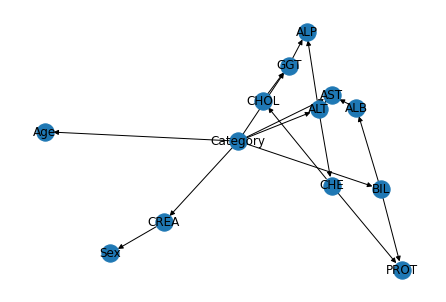

In [14]:
nx_graph = nx.DiGraph(best_model)
nx.draw(nx_graph, with_labels=True)
plb.show()

# Network for data considered as discrete variables

In pgmpy it is possible to learn the CPT of a given Bayesian network using either a Bayesian Estimator or a Maximum Likelihood Estimator (MLE). The former exploits a known prior distribution of data, the latter does not make any particular assumption.

MLE can overfit the data in case of small datasets, because there can be not enough observations and thus the observed frequencies can be not representative. Another problem with MLE is the fact that state counts are done conditionally for each parents configuration and this causes immense fragmentation since the state counts drop even more. The Bayesian estimator instead does not only rely on input data to learn the network parameters, but it also takes advantage of a prior knowledge, expressed through a prior distribution. In this way, the estimator does not have an absolute guide, but rather a reasonable starting assumption that allows to counterbalance the lack of data.

Although the MLE approach seems plausible, it can be overly simplistic in many cases, whereas the Bayesian one is intrinsically more robust. As a consequence the Bayesian estimator is choosen.

There are several prior distribuitions available in pgmpy, a sensible choice of prior is the Bayesian Dirichlet equivalent uniform prior (BDeu). In the learning process, using BDeu, N uniform samples are generated for each variable to compute the pseudo-counts (default is N=5), hence the estimated probabilities in CPT are more conservative than the ones obtained through MLE (i.e. probabilities close to 1 or 0 get smoothed).

In [16]:
model = BayesianNetwork(best_model)
print('\nLearning CPD using Maximum likelihood estimators')
model.fit(df,estimator=MaximumLikelihoodEstimator)

print('\n Inferencing with Bayesian Network:')
model_infer = VariableElimination(model)

print('\n 1. Probability of Hepatitis given evidence= Age')
q1=model_infer.query(variables=['Category'],evidence={'Age':64})
print(q1)

print('\n 2. Probability of Hepatitis given evidence= Sex ')
q2=model_infer.query(variables=['Category'],evidence={'Sex':1})
print(q2)


Learning CPD using Maximum likelihood estimators

 Inferencing with Bayesian Network:

 1. Probability of Hepatitis given evidence= Age
+-------------+-----------------+
| Category    |   phi(Category) |
+=============+=================+
| Category(0) |          1.0000 |
+-------------+-----------------+
| Category(1) |          0.0000 |
+-------------+-----------------+

 2. Probability of Hepatitis given evidence= Sex 
+-------------+-----------------+
| Category    |   phi(Category) |
+=============+=================+
| Category(0) |          0.9559 |
+-------------+-----------------+
| Category(1) |          0.0441 |
+-------------+-----------------+


In [ ]:
#model.get_cpds()

# Network for data with discretization

# Linear Gaussian Bayesian Network

LinearGaussianBayesianNetwork

Predicting values from new data points
Predicting values from new data points is quite similar to computing the conditional probabilities. We need to query for the variable that we need to predict given all the other features. The only difference is that rather than getting the probabilitiy distribution we are interested in getting the most probable state of the variable.

In pgmpy this is known as MAP query. Here’s an example:

# ME and NaN filling